In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import xgboost
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split
from helper_models import LogProbabilityMixin

XGBoost prints many warnings, that are safe to ignore:

In [2]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [3]:
df = pd.read_csv('day.csv', parse_dates=['dteday'])
df

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


For this research, I simplify the regression problem to a binary classification problem: To predict, whether the bike share count is above a certain threshold.

In [4]:
is_over_threshold = df['cnt'] > 4500

In order to make use of the unique properties of this dataset and investigate the suitability for analysing data drift, I split it in two parts: classifier A is trained on data of year 2011 and classifier B on data of year 2012. This dataset is well known for its characteristic that bike sharing became more popular over time.

In [5]:
is_part1 = df['dteday'] < datetime(2012, 1, 1)

<AxesSubplot:xlabel='dteday', ylabel='cnt'>

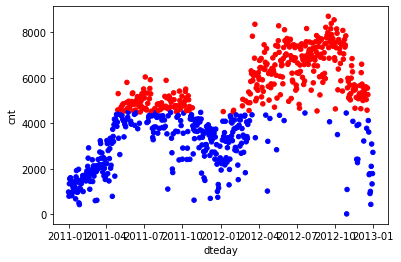

In [6]:
color = np.repeat('b', df.shape[0])
color[is_over_threshold] = 'r'
color
df.plot(x='dteday', y='cnt', kind='scatter', color=color)

I chose the threshold manually to yield similarly unbalanced training datasets.

In [7]:
np.sum(is_over_threshold[is_part1])

102

In [8]:
np.sum(~is_over_threshold[is_part1])

263

In [9]:
np.sum(is_over_threshold[~is_part1])

270

In [10]:
np.sum(~is_over_threshold[~is_part1])

96

I also remove the features yr and dteday from the dataset, because it doesn't contain usable information for the tasks.

In [11]:
feature_names = ['season', 'mnth', 'holiday', 'weekday', 'workingday',
                 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
X = df.loc[:, feature_names]
y = is_over_threshold.astype(int)

In [12]:
X_train1 = X[is_part1]
y_train1 = y[is_part1]
X_train2 = X[~is_part1]
y_train2 = y[~is_part1]

In [13]:
class XGBClassifierWithLogProbaPredict(xgboost.XGBClassifier, LogProbabilityMixin):
    pass

In [14]:
def make_classifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
    skf = StratifiedKFold(n_splits=10)
    best_score = 0
    for train_index, test_index in skf.split(X_train, y_train):
        clf = XGBClassifierWithLogProbaPredict(n_jobs=4, use_label_encoder=False, eval_metric='logloss')
        clf.fit(X.iloc[train_index], y.iloc[train_index])
        score = clf.score(X.iloc[test_index], y.iloc[test_index])
        if score > best_score:
            best_clf, best_score = clf, score
        print(score)
    print(classification_report(y_test, best_clf.predict(X_test)))
    return best_clf

In [15]:
%%time
clf_a = make_classifier(X_train1, y_train1)

1.0
1.0
0.9310344827586207
0.896551724137931
0.7241379310344828
0.7241379310344828
0.7931034482758621
0.6896551724137931
0.7586206896551724
0.6896551724137931
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        53
           1       0.91      1.00      0.95        20

    accuracy                           0.97        73
   macro avg       0.95      0.98      0.97        73
weighted avg       0.98      0.97      0.97        73

CPU times: user 2.76 s, sys: 132 ms, total: 2.89 s
Wall time: 964 ms


In [16]:
%%time
clf_b = make_classifier(X_train2, y_train2)

0.9666666666666667
0.9
0.8620689655172413
0.8275862068965517
0.896551724137931
0.9655172413793104
0.9655172413793104
0.9655172413793104
0.9310344827586207
0.896551724137931
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        19
           1       0.98      0.98      0.98        55

    accuracy                           0.97        74
   macro avg       0.96      0.96      0.96        74
weighted avg       0.97      0.97      0.97        74

CPU times: user 2.26 s, sys: 139 ms, total: 2.4 s
Wall time: 874 ms


In [17]:
print(classification_report(y_train2, clf_a.predict(X_train2)))

              precision    recall  f1-score   support

           0       0.40      1.00      0.57        96
           1       1.00      0.46      0.63       270

    accuracy                           0.60       366
   macro avg       0.70      0.73      0.60       366
weighted avg       0.84      0.60      0.61       366

